In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from regressors import stats
from sklearn.linear_model import LinearRegression

import tensorflow as tf
import tensorflow.keras.backend as K
print(f"Tensorflow version {tf.__version__}")


sys.path.append("../")
sys.path.append("../source_code")

from source_code import (
    utils,
    analysis
)
print("Last Modified: ", utils.current_timestamp())

Tensorflow version 2.5.0
Last Modified:  07-25-2021_22-38-49


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Dataset Overview

In [3]:
train_df.head(2)

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9


In [4]:
TARGET_COLUMNS =  [col for col in train_df.columns if 'target' in col]    
FEATURE_COLUMNS = [col for col in train_df.columns if col not in TARGET_COLUMNS]
NUM_FEATURE_COLUMNS = train_df[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [6]:
train_df.isnull().sum()

date_time                 0
deg_C                     0
relative_humidity         0
absolute_humidity         0
sensor_1                  0
sensor_2                  0
sensor_3                  0
sensor_4                  0
sensor_5                  0
target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
dtype: int64

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
deg_C,7111.0,20.878034,7.937917,1.3000,14.9000,20.7000,25.80000,46.100
relative_humidity,7111.0,47.561004,17.398731,8.9000,33.7000,47.3000,60.80000,90.800
absolute_humidity,7111.0,1.110309,0.398950,0.1988,0.8559,1.0835,1.40415,2.231
sensor_1,7111.0,1091.572100,218.537554,620.3000,930.2500,1060.5000,1215.80000,2088.300
sensor_2,7111.0,938.064970,281.978988,364.0000,734.9000,914.2000,1124.10000,2302.600
sensor_3,7111.0,883.903305,310.456355,310.6000,681.0500,827.8000,1008.85000,2567.400
sensor_4,7111.0,1513.238349,350.180310,552.9000,1320.3500,1513.1000,1720.40000,2913.800
sensor_5,7111.0,998.335565,381.537695,242.7000,722.8500,928.7000,1224.70000,2594.600
target_carbon_monoxide,7111.0,2.086219,1.447109,0.1000,1.0000,1.7000,2.80000,12.500
target_benzene,7111.0,10.237083,7.694426,0.1000,4.5000,8.5000,14.20000,63.700


In [8]:
train_df[TARGET_COLUMNS].head(2)

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2.5,12.0,167.7
1,2.1,9.9,98.9


In [9]:
# sns.pairplot(train_df)

# Correlation Analysis

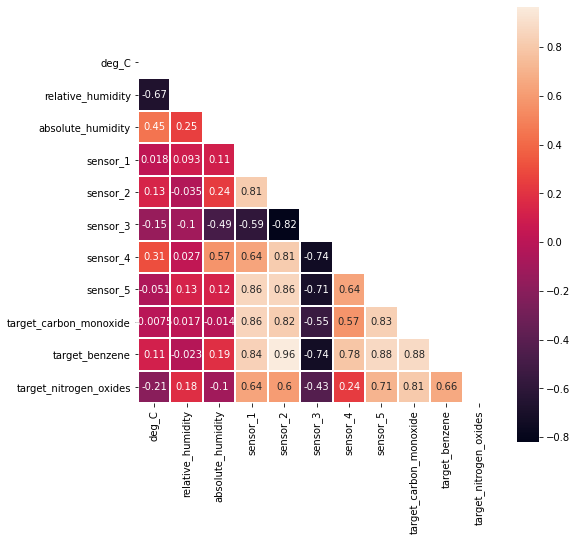

In [10]:
analysis.correlation_heatmap(train_df)

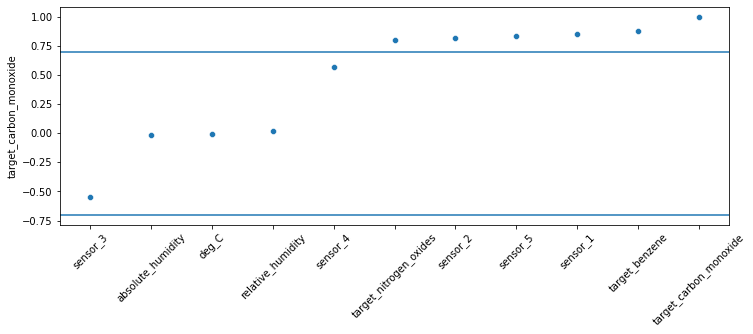

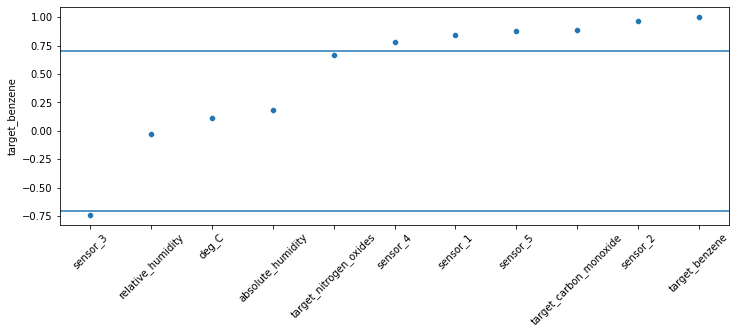

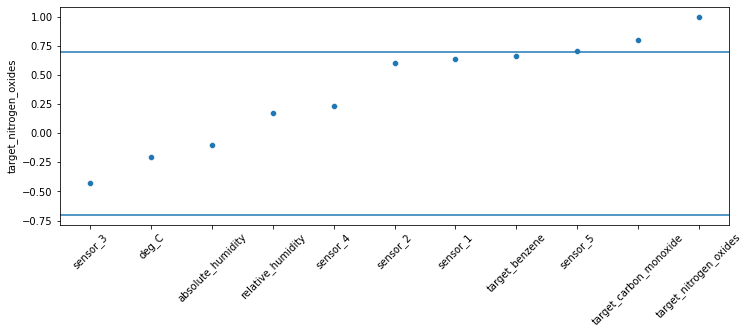

In [11]:
for col in TARGET_COLUMNS:
    analysis.correlation_1d_plot(train_df, col)

## Multi Collinearity
### Variance Inflation Factor

In [12]:
analysis.vif_multicollinearity_analysis(train_df, test_df, NUM_FEATURE_COLUMNS)

,vif_train,vif_test
features,,
deg_C,7.684437,19.558357
relative_humidity,6.924917,5.360906
absolute_humidity,7.301133,45.126694
sensor_1,4.955588,6.519055
sensor_2,12.092791,20.815807
sensor_3,4.865959,5.560978
sensor_4,5.672586,46.057502
sensor_5,6.480421,7.434546


## Insights:

* usually a vif value of 10 is a good threshold to use. If value > 10 then we need to deal with this issue, how?:
    * PCA to reduce features and collinearity
    * delete some of the features
    
* sensor_2 in training dataset is high
* absolute_humiditiy and sensor_4 are very hgih in test data

In [13]:
from scipy.stats import kurtosis, skew

def train_test_split_statistics(train_df: pd.DataFrame, test_df: pd.DataFrame):
    features = train_df.columns
    features = [col for col in features if col in test_df.columns]
    
    features = train_df[features].select_dtypes(include=np.number).columns.tolist()
    
    tmp_train_df = train_df[features]
    tmp_test_df = test_df[features]
    
    stats_df = pd.DataFrame({"metric":"Skewness","train": skew(tmp_train_df),"test": skew(tmp_test_df)}, index=features)
    stats_df = stats_df.append(pd.DataFrame({"metric":"Kurtosis","train": kurtosis(tmp_train_df),"test": kurtosis(tmp_test_df)}, index=features))
    
    return stats_df.T

In [14]:
train_test_split_statistics(train_df, test_df)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
metric,Skewness,Skewness,Skewness,Skewness,Skewness,Skewness,Skewness,Skewness,Kurtosis,Kurtosis,Kurtosis,Kurtosis,Kurtosis,Kurtosis,Kurtosis,Kurtosis
train,0.290257,0.078605,-0.035883,0.795756,0.417752,1.406932,-0.126604,0.768128,-0.31371,-0.819154,-0.320169,0.613923,0.115731,2.616898,0.807323,0.399359
test,0.676809,0.059528,0.467095,0.719301,0.447822,1.511802,0.423329,0.533868,-0.284563,-0.812126,-0.52587,0.303368,-0.251095,2.211505,-0.015306,-0.221094


# Distribution of Target

<AxesSubplot:ylabel='count'>

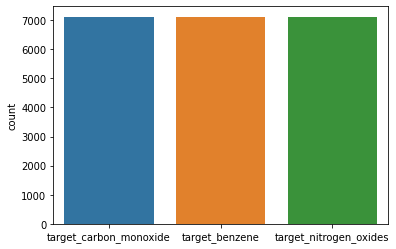

In [15]:
sns.countplot(data=train_df[TARGET_COLUMNS])

<AxesSubplot:xlabel='target_nitrogen_oxides', ylabel='Density'>

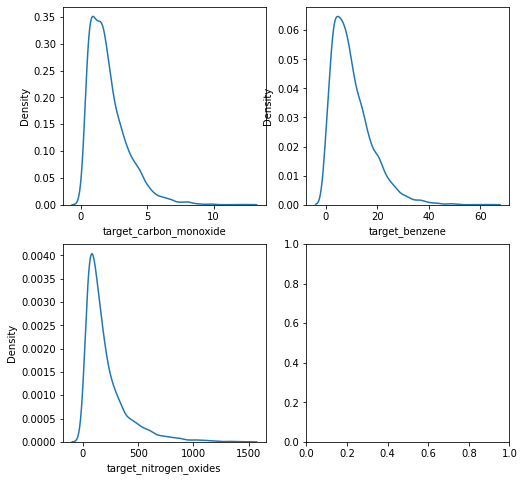

In [16]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
sns.kdeplot(data=train_df[TARGET_COLUMNS[0]],ax=axes[0,0])
sns.kdeplot(data=train_df[TARGET_COLUMNS[1]],ax=axes[0,1])
sns.kdeplot(data=train_df[TARGET_COLUMNS[2]],ax=axes[1,0])

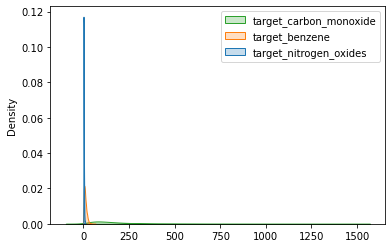

In [17]:
sns.kdeplot(data=train_df[TARGET_COLUMNS],shade=True)
plt.legend(TARGET_COLUMNS)

# Compare Target with features

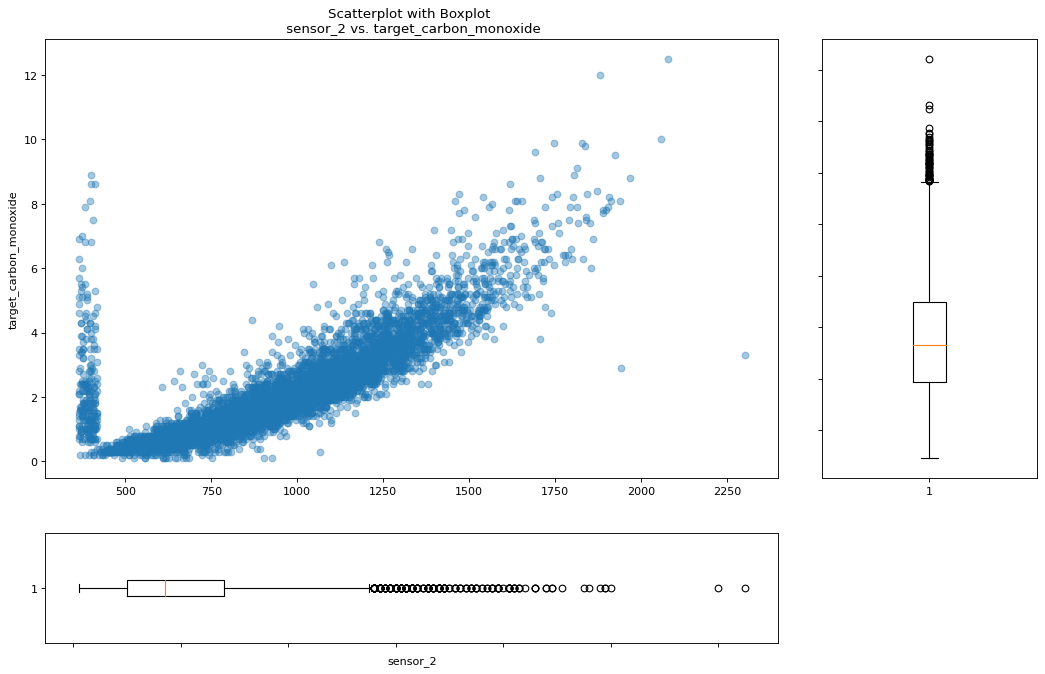

In [18]:
analysis.grid_spec_scatter_plot(train_df, 'sensor_2', TARGET_COLUMNS[0])

# Features over time

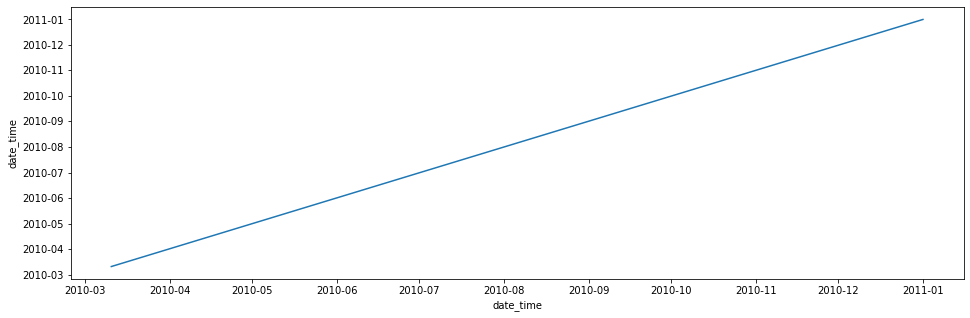

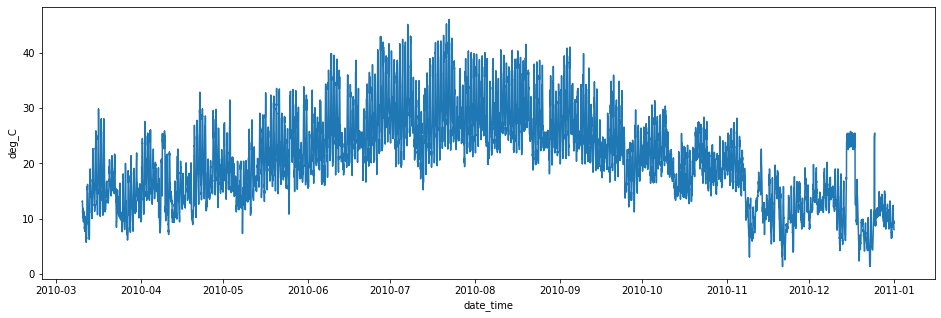

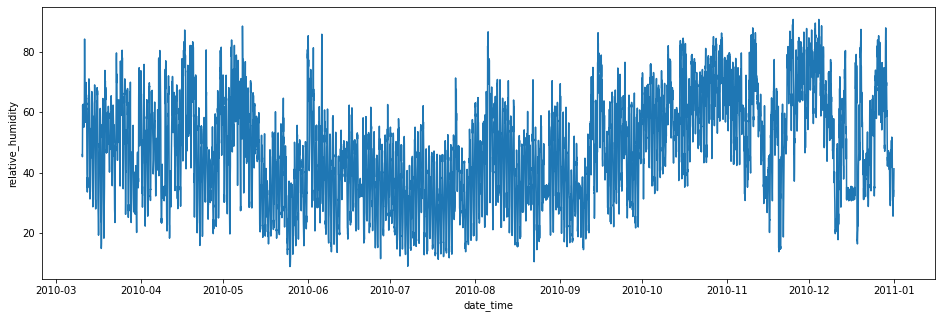

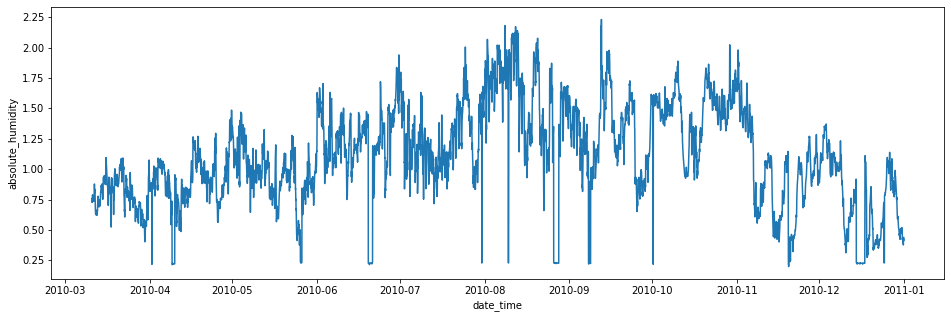

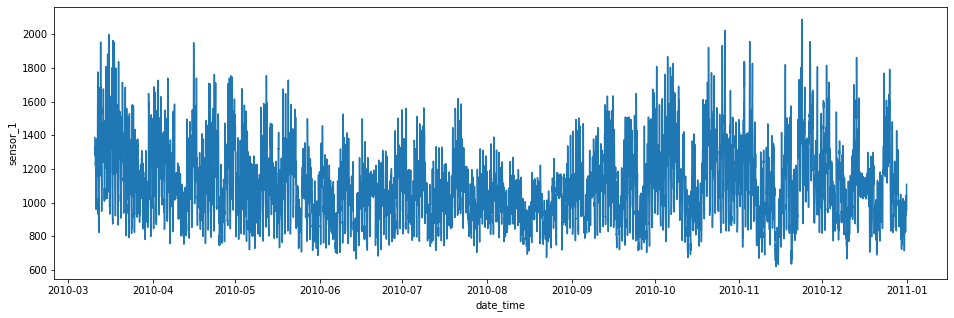

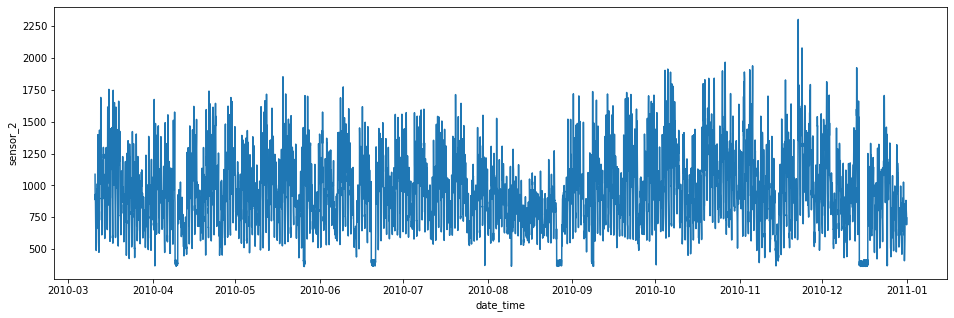

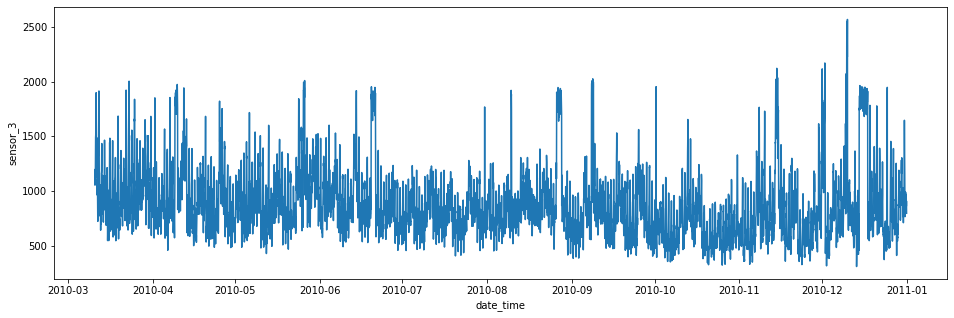

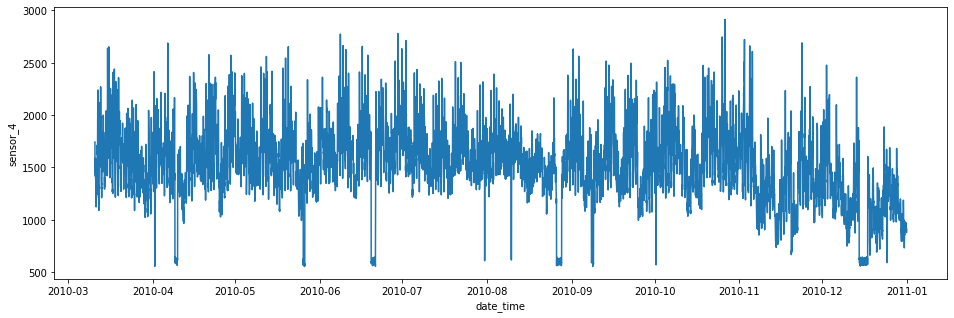

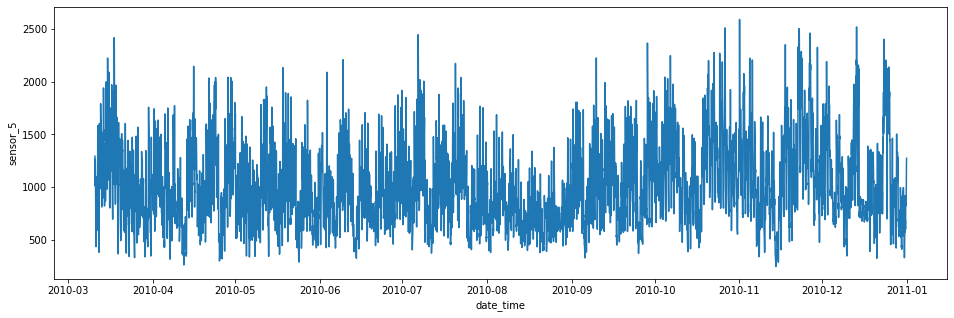

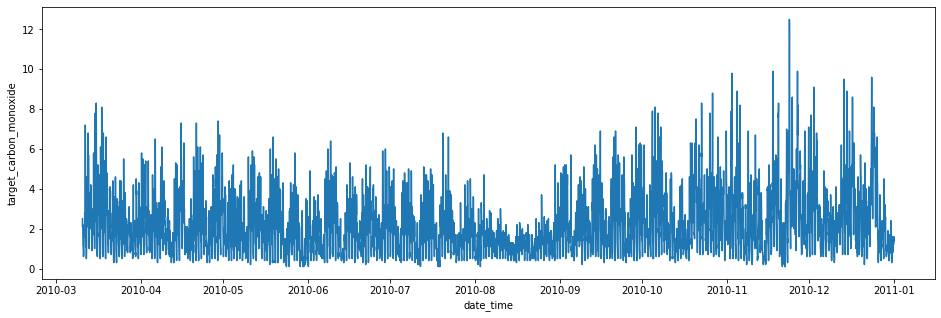

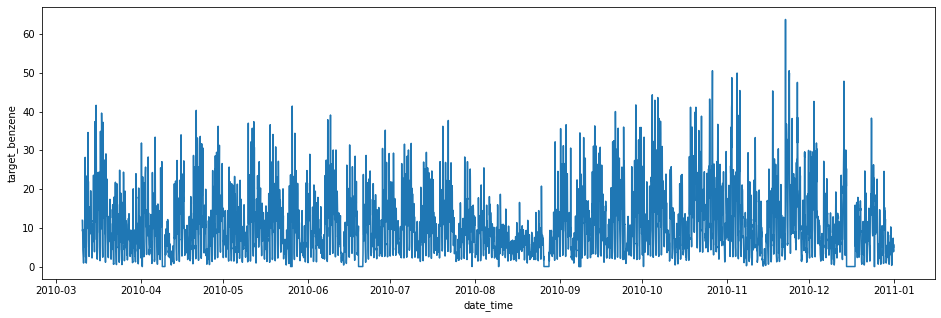

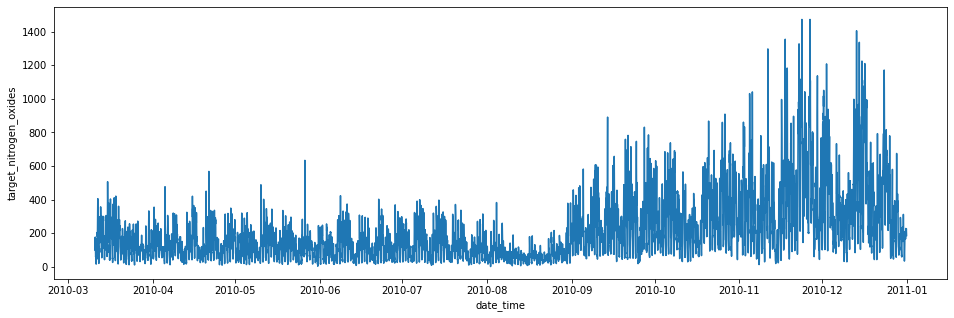

In [19]:
for col in train_df.columns:
    analysis.plot_feature_over_datetime(train_df, 'date_time', col)

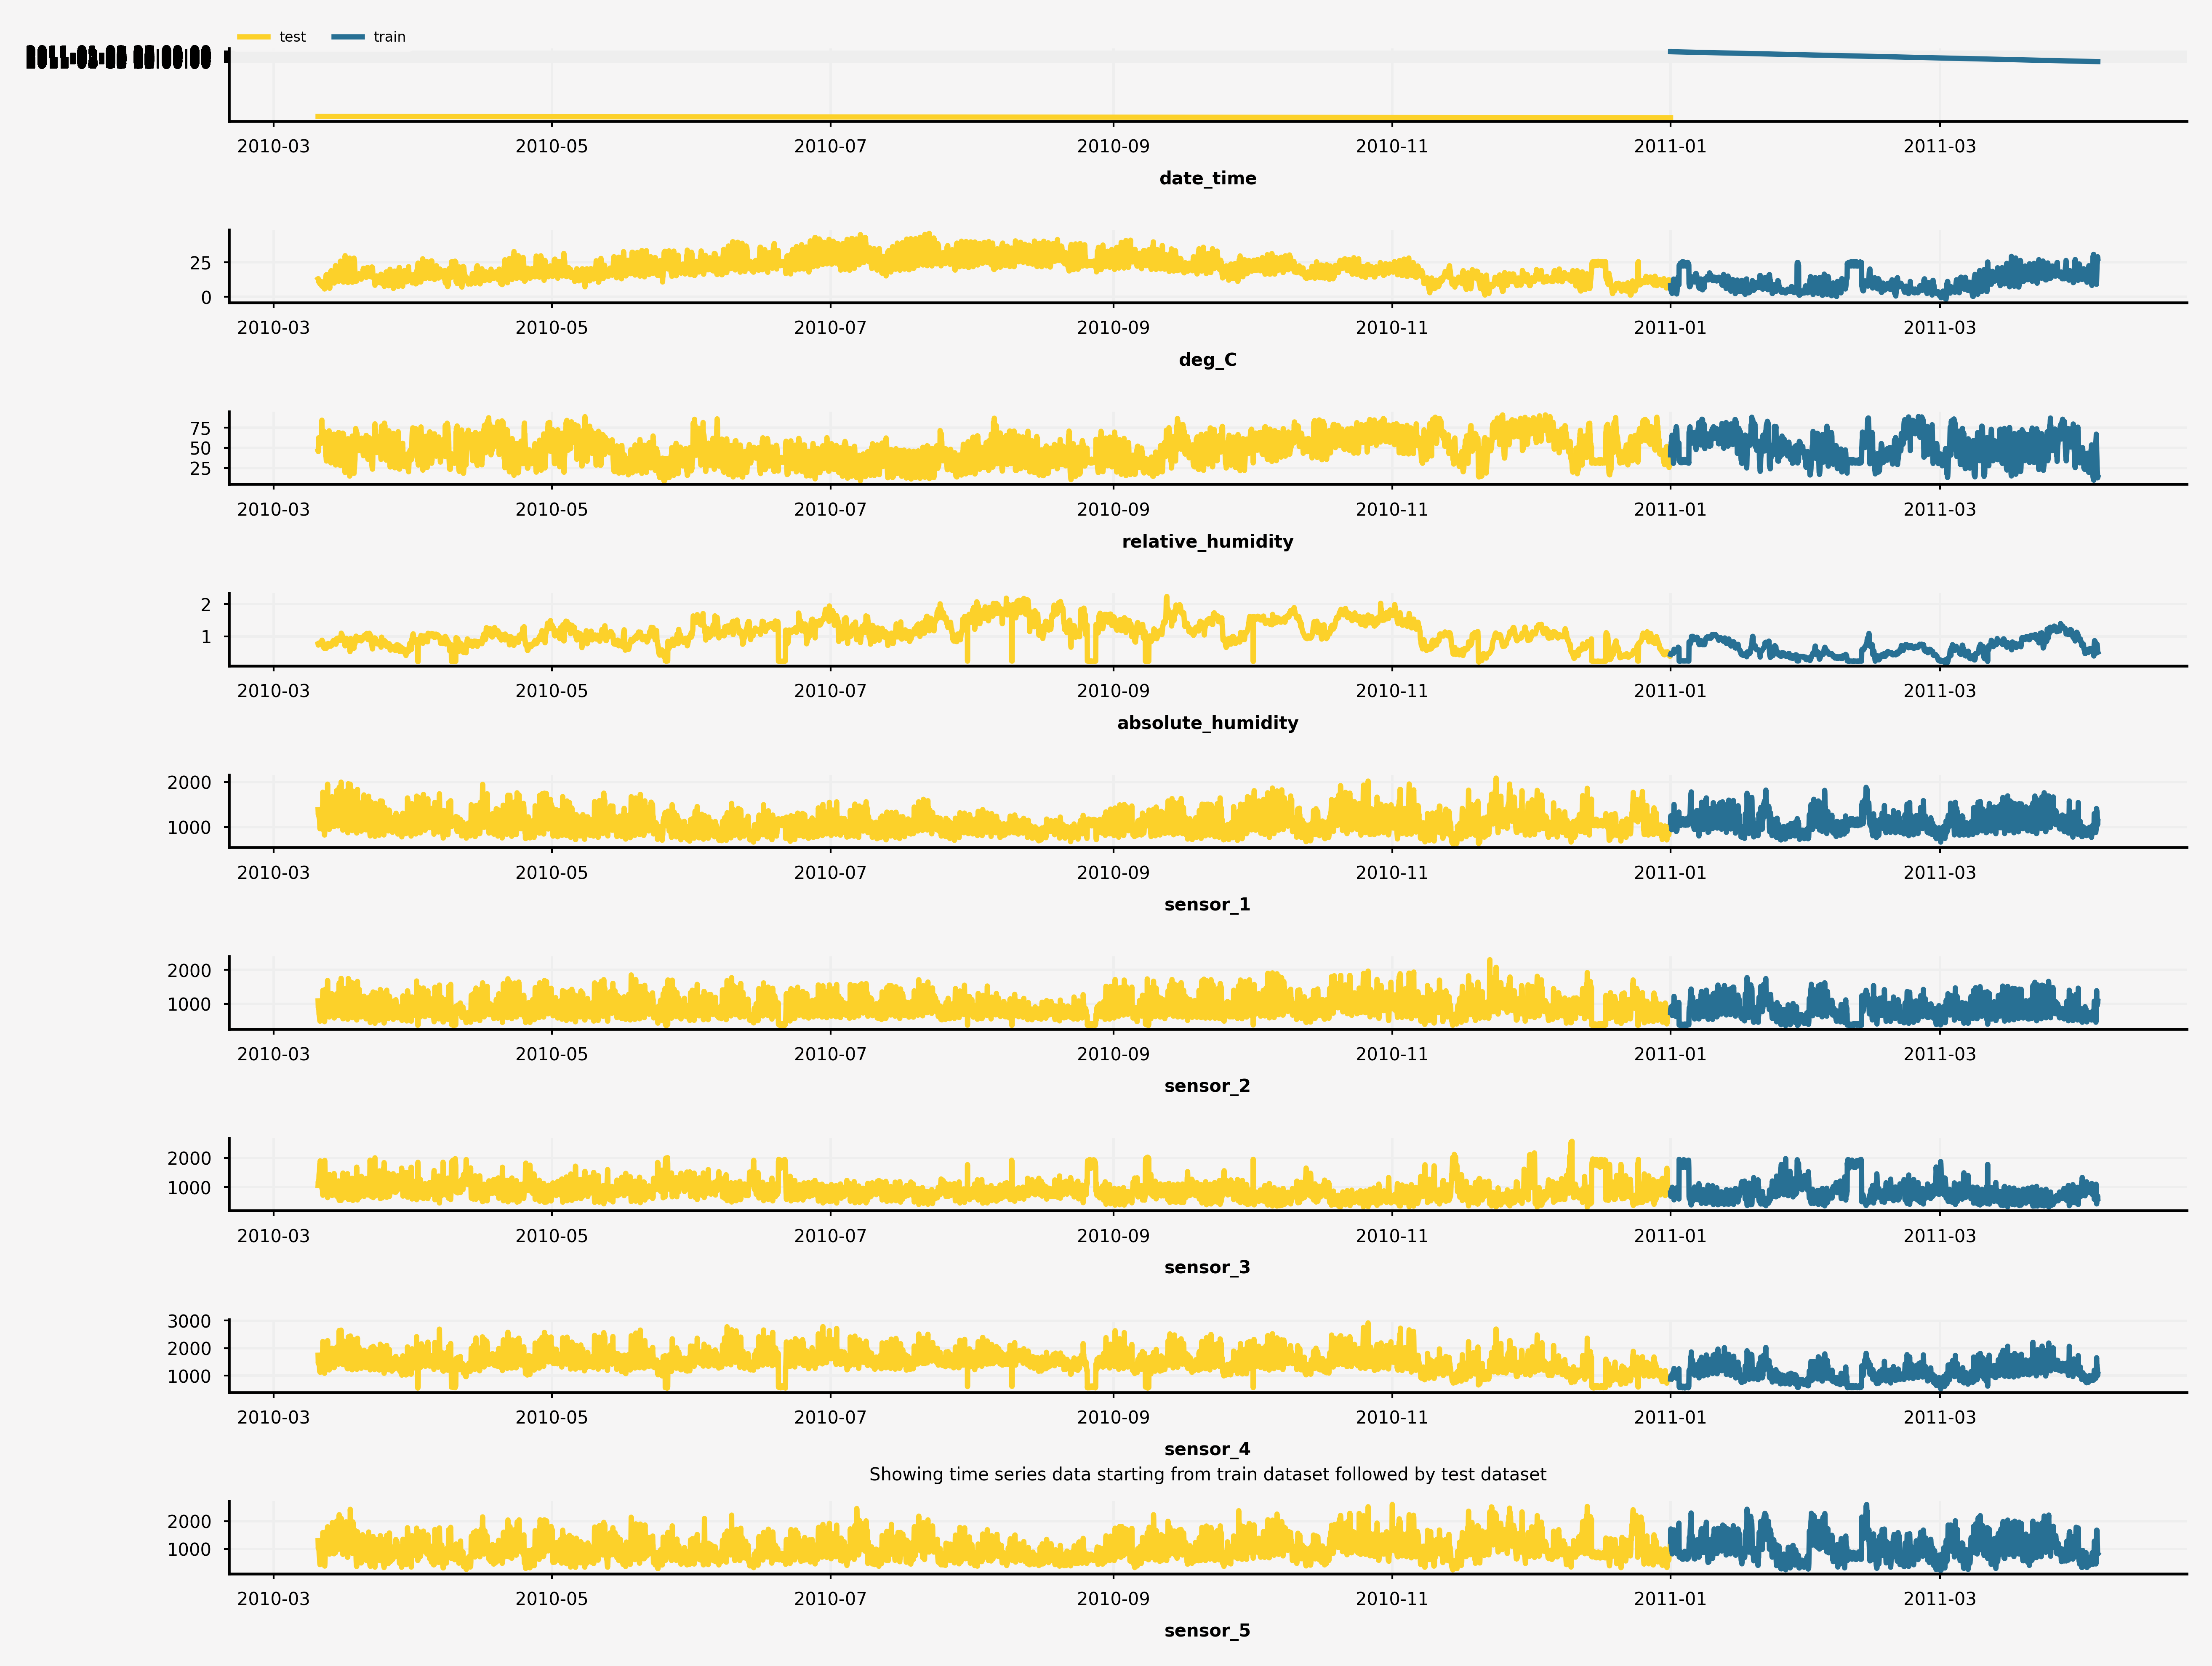

In [20]:
analysis.timeseries_plot(train_df, test_df, 'date_time', FEATURE_COLUMNS)

In [21]:
analysis.skew_and_kurtosis_table(train_df.iloc[:,1:])

,Skewness,Kurtosis
deg_C,0.290257,-0.313710
relative_humidity,0.078605,-0.819154
absolute_humidity,-0.035883,-0.320169
sensor_1,0.795756,0.613923
sensor_2,0.417752,0.115731
sensor_3,1.406932,2.616898
sensor_4,-0.126604,0.807323
sensor_5,0.768128,0.399359
target_carbon_monoxide,1.468903,3.093527
target_benzene,1.324660,2.426201


In [22]:
analysis.skew_and_kurtosis_table(test_df.iloc[:,1:])

,Skewness,Kurtosis
deg_C,0.676809,-0.284563
relative_humidity,0.059528,-0.812126
absolute_humidity,0.467095,-0.525870
sensor_1,0.719301,0.303368
sensor_2,0.447822,-0.251095
sensor_3,1.511802,2.211505
sensor_4,0.423329,-0.015306
sensor_5,0.533868,-0.221094


## ACF Analysis

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

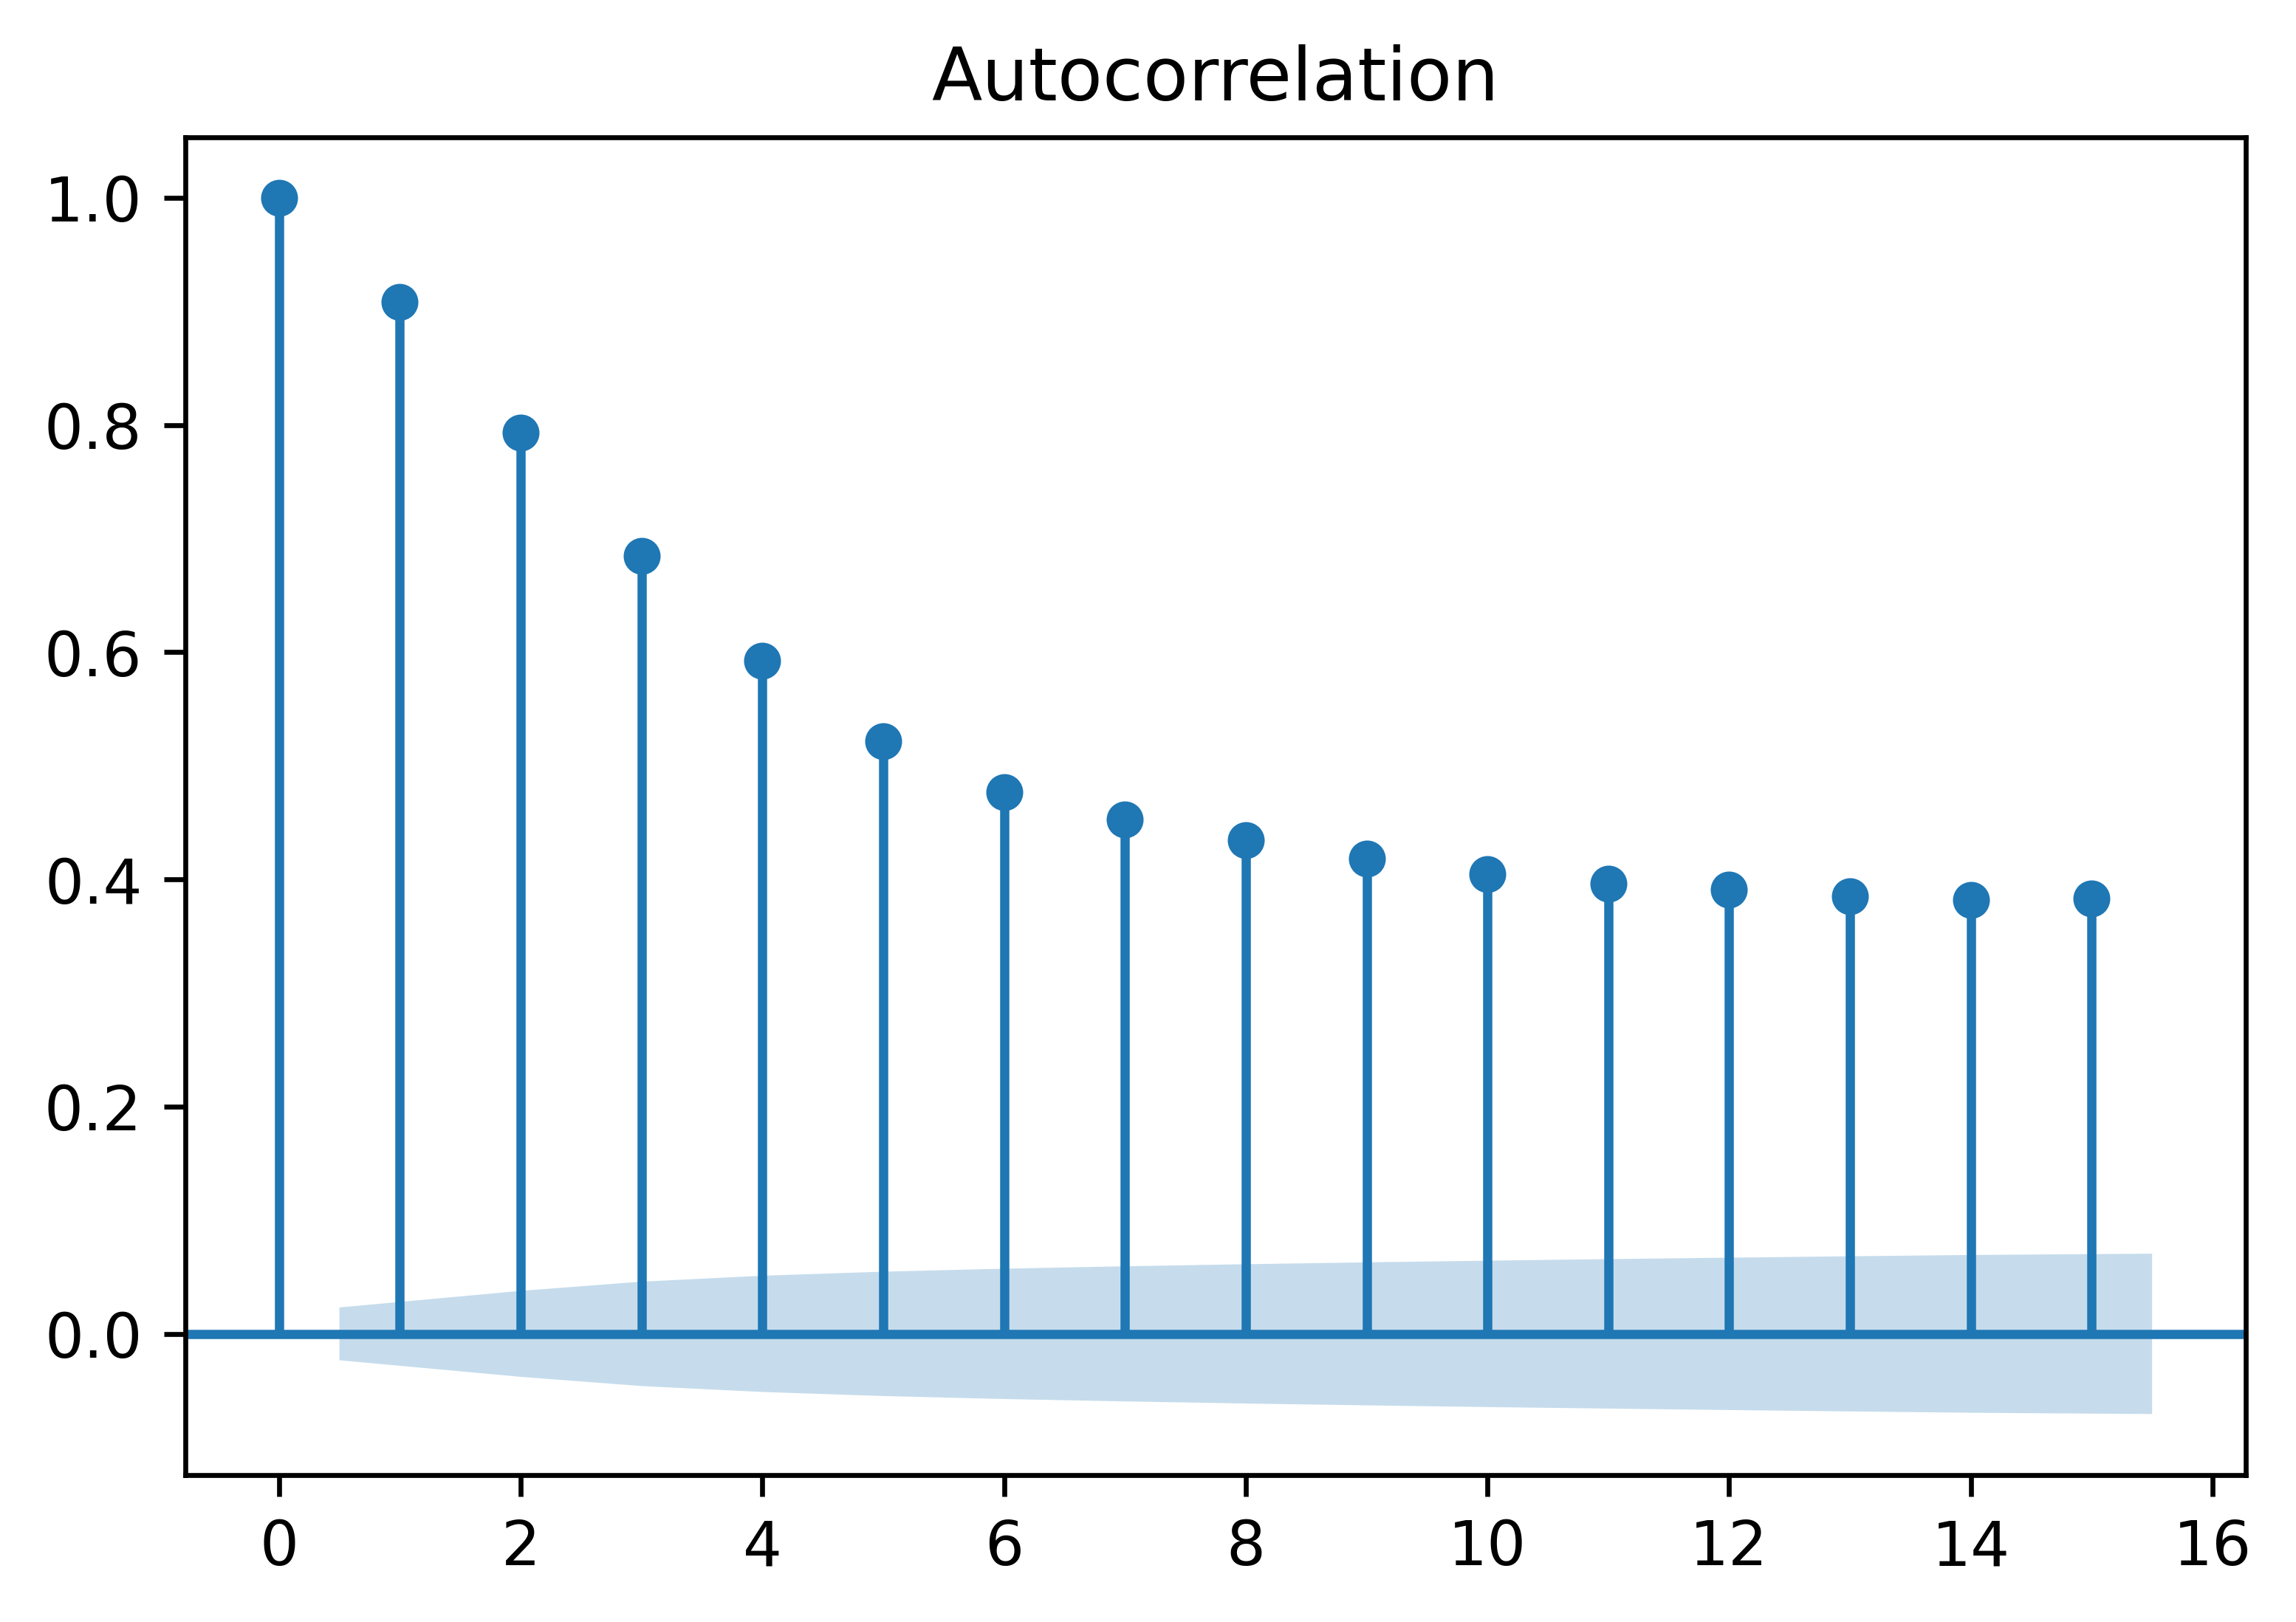

In [24]:
_ = sm.graphics.tsa.plot_acf(train_df[TARGET_COLUMNS[2]], lags=15)

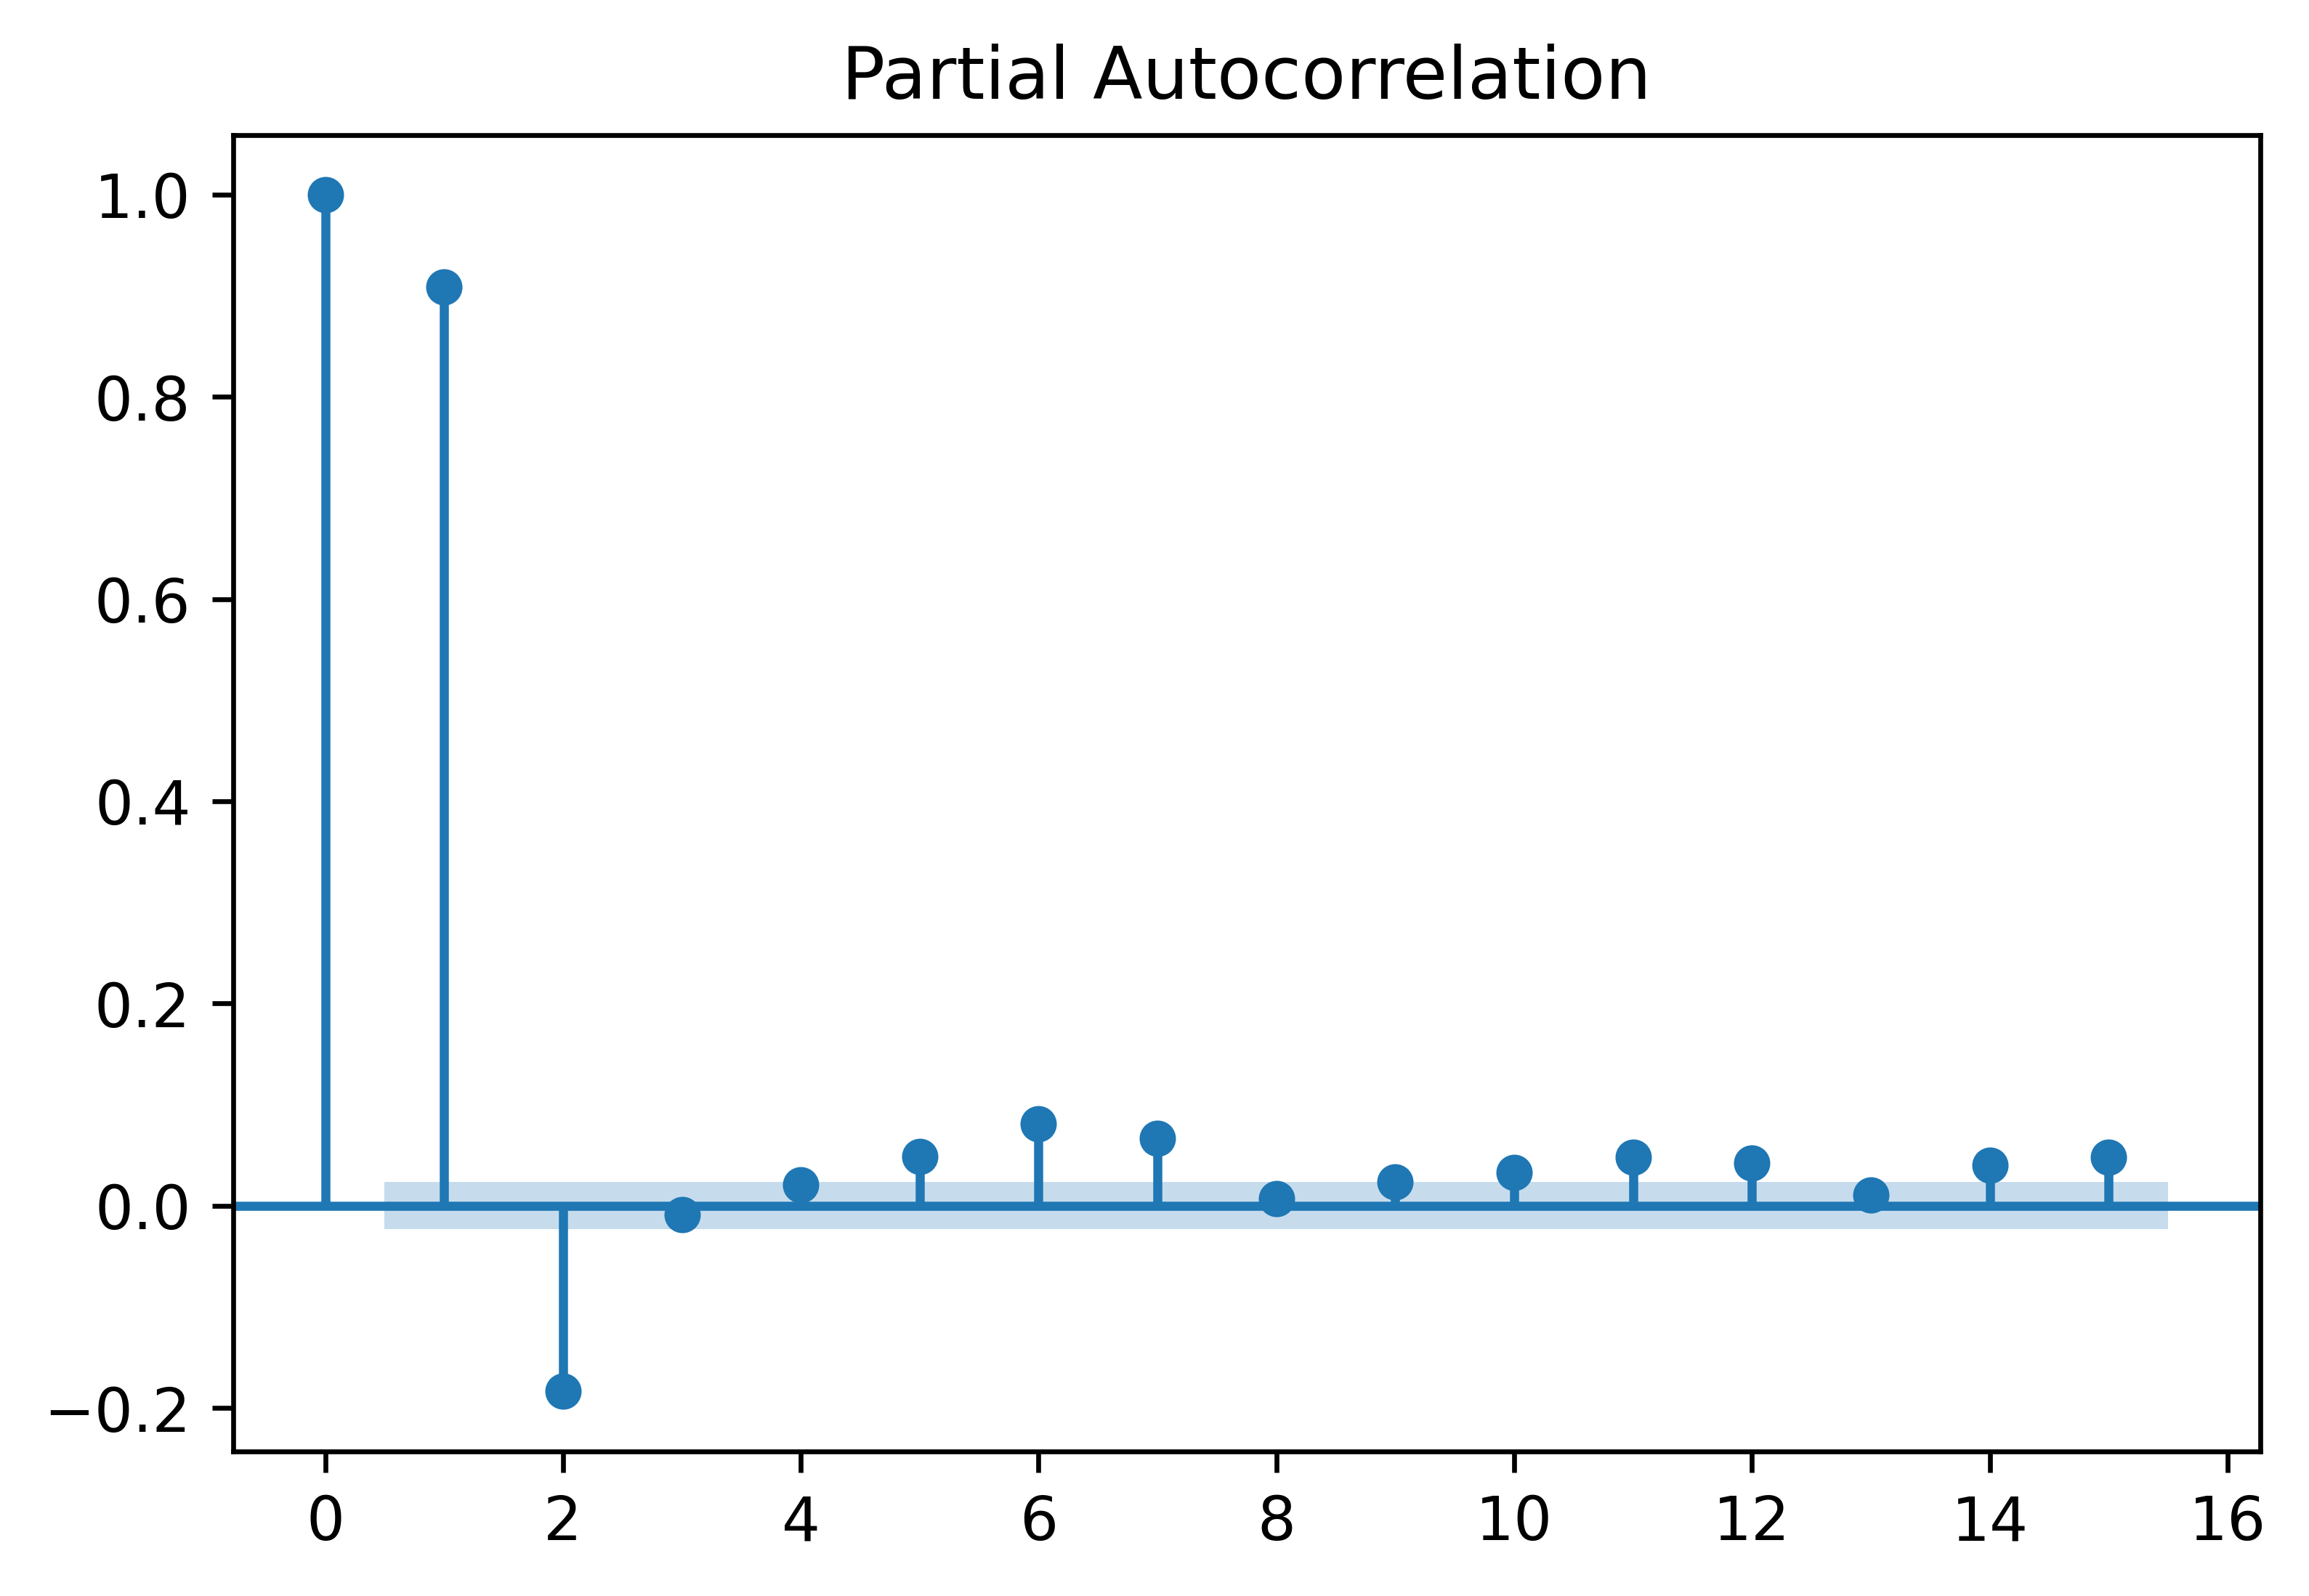

In [25]:
_ = sm.graphics.tsa.plot_pacf(train_df[TARGET_COLUMNS[2]], lags=15)

# Linear Regression Summary Statistics


 
  TARGET_CARBON_MONOXIDE 
 
 
Residuals:
    Min      1Q  Median     3Q    Max
-6.8663 -0.2414  0.0327 0.3126 4.6729


Coefficients:
                   Estimate  Std. Error  t value  p value
_intercept        -4.879906    0.105415 -46.2925      0.0
deg_C              0.025381    0.001357  18.7059      0.0
relative_humidity  0.011472    0.000489  23.4494      0.0
absolute_humidity -0.604254    0.048205 -12.5350      0.0
sensor_1           0.002446    0.000061  39.8261      0.0
sensor_2           0.003241    0.000066  48.8495      0.0
sensor_3           0.000913    0.000018  50.9361      0.0
sensor_4          -0.000442    0.000026 -17.0725      0.0
sensor_5           0.000715    0.000038  19.0307      0.0
---
R-squared:  0.82760,    Adjusted R-squared:  0.82741
F-statistic: 4261.69 on 8 features


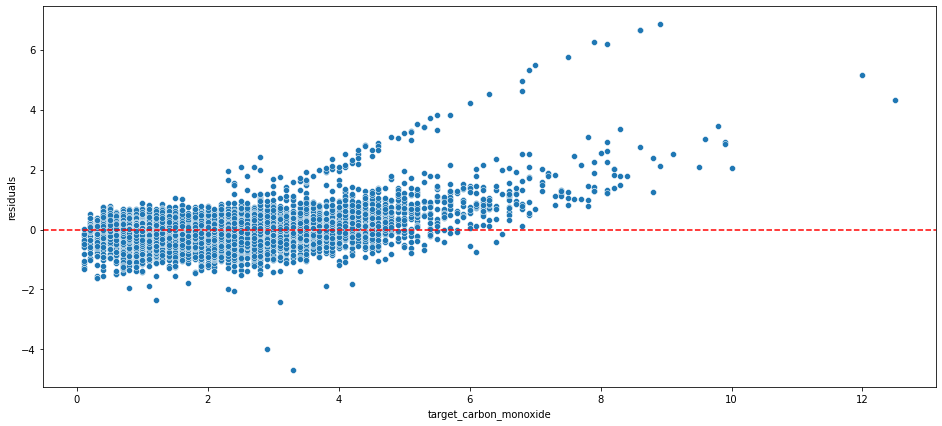

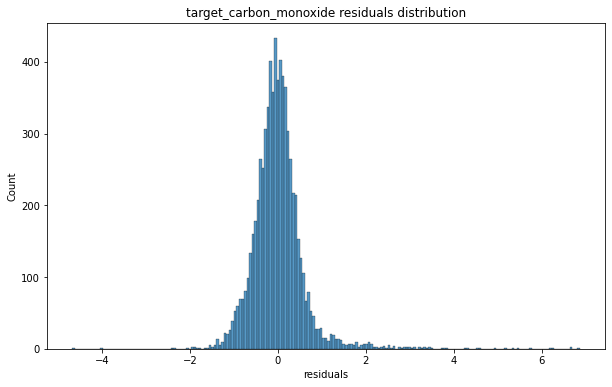

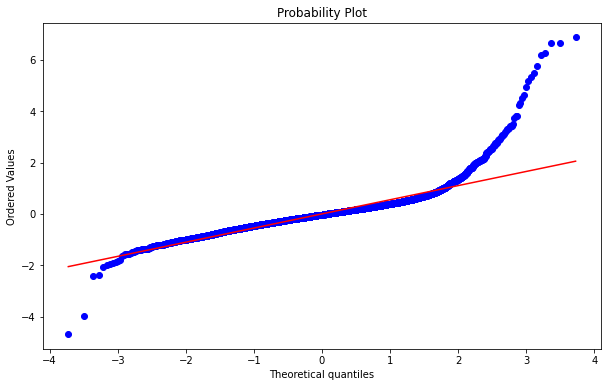


 
  TARGET_BENZENE 
 
 
Residuals:
     Min      1Q  Median     3Q    Max
-18.5691 -0.9537  0.0328 1.0752 7.2757


Coefficients:
                    Estimate  Std. Error   t value   p value
_intercept        -23.517748    0.301360  -78.0386  0.000000
deg_C               0.023492    0.003879    6.0562  0.000000
relative_humidity   0.007785    0.001399    5.5662  0.000000
absolute_humidity  -0.402510    0.137809   -2.9208  0.003503
sensor_1            0.002479    0.000176   14.1200  0.000000
sensor_2            0.023315    0.000190  122.9115  0.000000
sensor_3            0.003905    0.000051   76.2245  0.000000
sensor_4            0.001560    0.000074   21.0569  0.000000
sensor_5            0.002956    0.000107   27.5364  0.000000
---
R-squared:  0.95016,    Adjusted R-squared:  0.95011
F-statistic: 16925.34 on 8 features


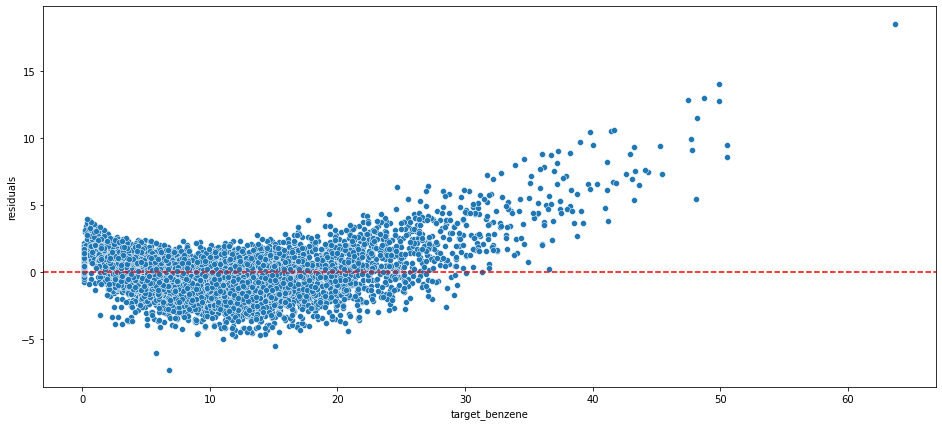

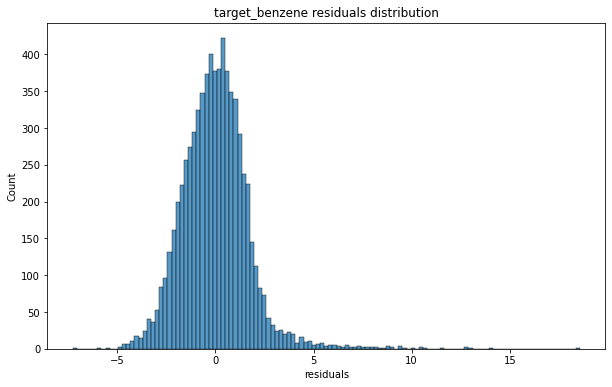

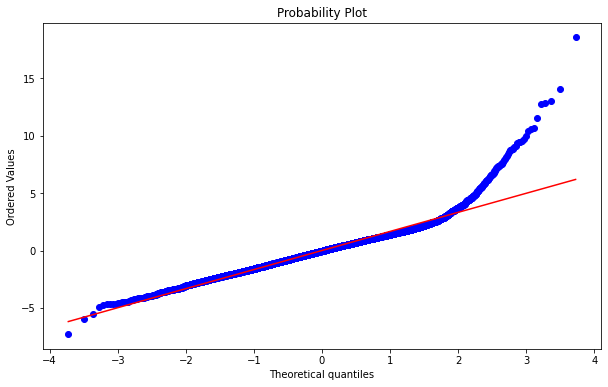


 
  TARGET_NITROGEN_OXIDES 
 
 
Residuals:
      Min       1Q  Median      3Q      Max
-1074.393 -42.5495  7.0536 58.6306 428.5203


Coefficients:
                     Estimate  Std. Error  t value   p value
_intercept        -311.965924   19.266975 -16.1917  0.000000
deg_C                3.002957    0.247995  12.1089  0.000000
relative_humidity    2.927505    0.089418  32.7395  0.000000
absolute_humidity    0.088526    8.810619   0.0100  0.991984
sensor_1             0.132228    0.011227  11.7779  0.000000
sensor_2             0.599957    0.012127  49.4715  0.000000
sensor_3             0.070553    0.003275  21.5421  0.000000
sensor_4            -0.425937    0.004737 -89.9166  0.000000
sensor_5             0.189366    0.006864  27.5883  0.000000
---
R-squared:  0.67931,    Adjusted R-squared:  0.67895
F-statistic: 1880.54 on 8 features


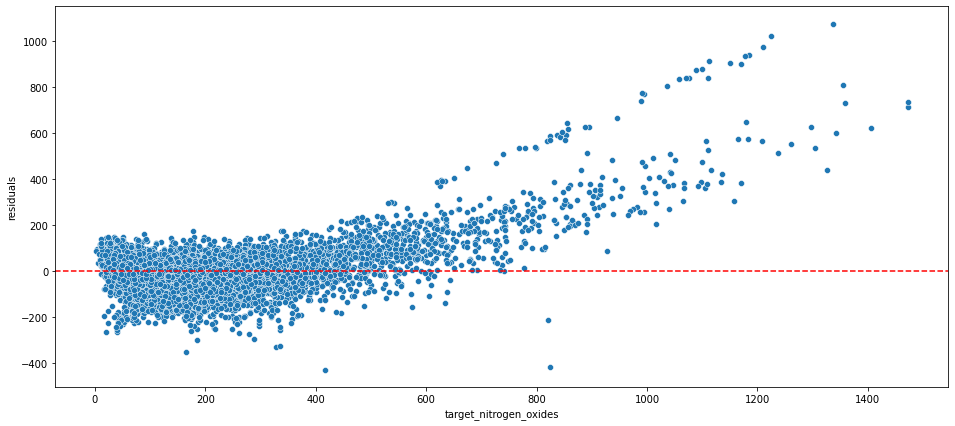

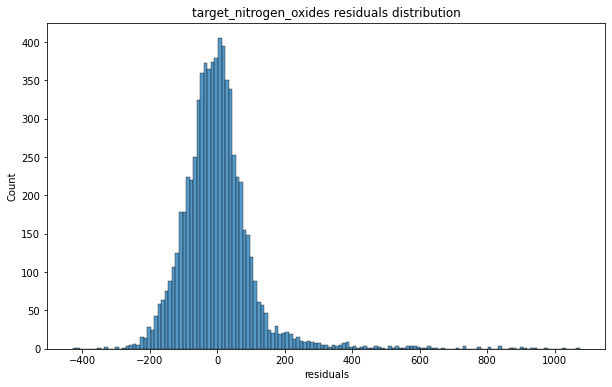

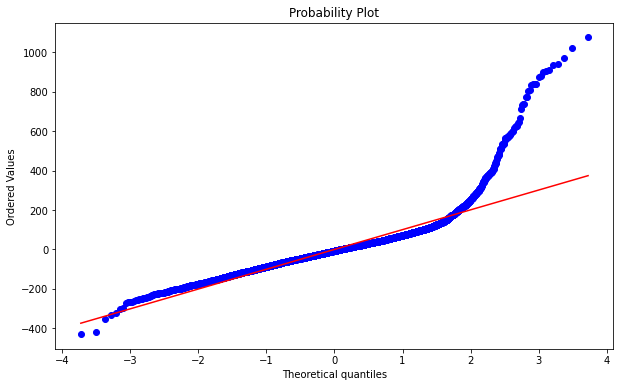

In [14]:
import time as time
for target in TARGET_COLUMNS:
    print("\n \n ",target.upper(), '\n \n ')
    time.sleep(0.01)
    ols, summary = analysis.ols_summary_statistics(train_df[NUM_FEATURE_COLUMNS], train_df[target])
    residuals = analysis.plot_residuals(ols, train_df[NUM_FEATURE_COLUMNS], train_df[target])
    analysis.plot_residuals_dist(ols, train_df[NUM_FEATURE_COLUMNS], train_df[target])
    _ = analysis.probability_plot(ols, train_df[NUM_FEATURE_COLUMNS], train_df[target])
    plt.show()

In [14]:
summary

,estimates,std-error,t-value,p-value
intercept,-311.965924,19.266975,-16.191744,0.000000
deg_C,3.002957,0.247995,12.108948,0.000000
relative_humidity,2.927505,0.089418,32.739472,0.000000
absolute_humidity,0.088526,8.810619,0.010048,0.991984
sensor_1,0.132228,0.011227,11.777930,0.000000
sensor_2,0.599957,0.012127,49.471510,0.000000
sensor_3,0.070553,0.003275,21.542138,0.000000
sensor_4,-0.425937,0.004737,-89.916629,0.000000
sensor_5,0.189366,0.006864,27.588305,0.000000


## Insights:

* absolute_humidity can be dropped when predicting `TARGET_NITROGEN_OXIDES`

Remember we are trying to prove Ho. 

So a p-value lest then alpha => we were not able to find 1 in 20 'samples' => we reject Ho. 
But since p-value of absolute_humidity > alpha then we cannot reject Ho, i.e. there is no correlation between this feature and the target featre `TARGET_NITROGEN_OXIDES`.


Note: 

> The p-value for each independent variable tests the null hypothesis that the variable has no correlation with the dependent variable.A small p-value is an indication that the null hypothesis is false. It is good practice to decide in advance of the test how small a p-value is required to reject the test. P-value and t-value are inextricably linked. T-value measures the size of the difference relative to the variation in your sample data. The greater the magnitude of T, the greater the evidence against the null hypothesis. This means there is greater evidence that there is a significant difference. The closer T is to 0, the more likely there isn't a significant difference.

# Residuals

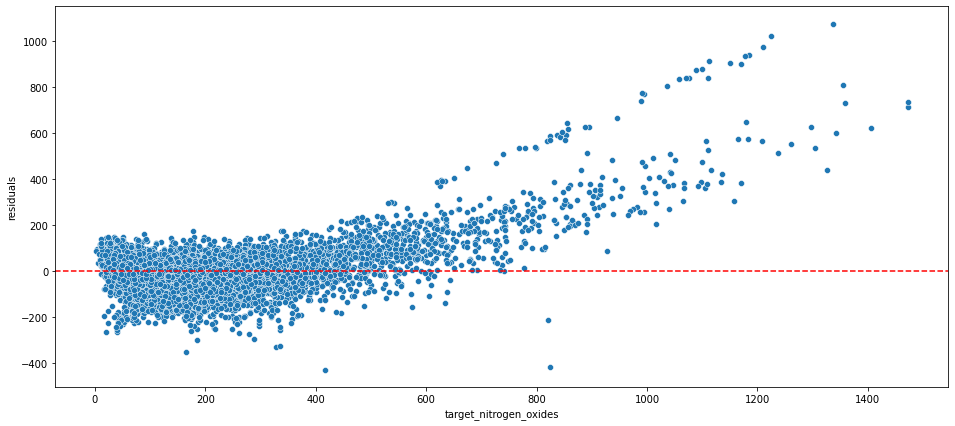

In [23]:
plot_residuals(ols, train_df[NUM_FEATURE_COLUMNS], train_df[TARGET_COLUMNS[2]])

1. The residuals should fall in a symmetrical pattern and have a constant spread throughout the range.
2. The non-random pattern in the residuals indicates that the deterministic portion (predictor variables) of the model is not capturing some explanatory information that is “leaking” into the residuals. Possibilities include:
    * A missing variable
    * A missing higher-order term of a variable in the model to explain the curvature
    * A missing interaction between terms already in the model

Identifying and fixing the problem so that the predictors now explain the information that they missed before should produce a good-looking set of residuals!

In addition to the above, here are two more specific ways that predictive information can sneak into the residuals:

* The residuals should not be correlated with another variable.
* Adjacent residuals should not be correlated with each other (autocorrelation). If you can use one residual to predict the next residual, there is some predictive information present that is not captured by the predictors. Typically, this situation involves time-ordered observations. For example, if a residual is more likely to be followed by another residual that has the same sign, adjacent residuals are positively correlated. You can include a variable that captures the relevant time-related information, or use a time series analysis. In regression, you can perform the Durbin-Watson test to test for autocorrelation.

((array([-3.72548352, -3.49549336, -3.36899565, ...,  3.36899565,
          3.49549336,  3.72548352]),
  array([-428.52026895, -416.62896789, -351.40091926, ...,  971.61013105,
         1022.04235983, 1074.39299544])),
 (100.37041061119007, 4.092790107823612e-15, 0.9135781688969088))

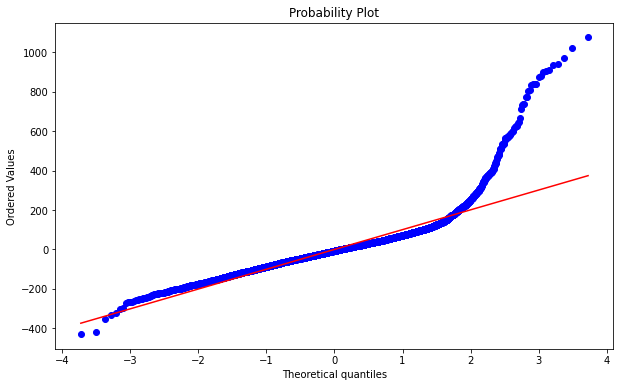

In [23]:
analysis.probability_plot(ols, train_df[NUM_FEATURE_COLUMNS], train_df[TARGET_COLUMNS[2]])

# Probability Plots

The probability plot is a graphical technique for assessing whether or not a data set follows a given distribution such as the normal. The data are plotted against a theoretical distribution in such a way that the points should form approximately a straight line. Departures from this straight line indicate departures from the specified distribution. It indicates that your distribution has:

* Right Skew - If the plotted points appear to bend up and to the left of the normal line that indicates a long tail to the right.
* Left Skew - If the plotted points bend down and to the right of the normal line that indicates a long tail to the left.

# Stationarity

Main assumption of timeseries analysis is that the time series is stationary.

A timeseries is said to be **stationary** if it has constant statistical properties over time, i.e.:
    * constant mean
    * constant variance
    * an autocovariance that does not depend on time

We check this by:

* Plotting Rolling Statistics: Plot the moving average and moving variance and examine if it varies with time, this is more of a visual technique.
* Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.


### Note on LSTM:
The LSTM method is preferable over other existing algorithms as LSTM network is able to learn non-linear and non-stationary nature of a time series which reduces error in forecasting

In [16]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
test_df['date_time'] = pd.to_datetime(test_df['date_time'])

In [17]:
# Feature engineering
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['hour'] = train_df['date_time'].dt.hour
train_df['day'] = train_df['date_time'].dt.day

test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['hour'] = test_df['date_time'].dt.hour
test_df['day'] = test_df['date_time'].dt.day

In [18]:
analysis.dicky_fuller_test_for_stationarity(train_df[TARGET_COLUMNS[0]])

Test Statistic                -8.982103e+00
p-value                        7.263414e-15
#Lags Used                     3.300000e+01
Number of Observations Used    7.077000e+03
Critical Value (1%)           -3.431274e+00
Critical Value (5%)           -2.861948e+00
Critical Value (10%)          -2.566987e+00
dtype: float64

## Test Interpretation

The null hypothesis (H0) of the test is that:
* the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure).
* The alternate hypothesis (H1) (rejecting the null hypothesis) is that the time series is stationary.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

## Rolling statistics for training and test datasets